## Одномерное уравнение переноса
Для первичного тестирования численных схем часто используют одномерное уравнение переноса. Пусть ветер дует только вдоль оси $x$ и постоянен, $v_x = c$, предположим также периодичские граничные условия:
\begin{align}
&\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0, \ x \in [0,2\pi), \ c>0, \\
&u(t,0) = u(t,2\pi).
\end{align}


Для одномерного уравнения переноса с постоянной скоростью есть аналитическое решение. Если $u(t=0,x) = u_0(x)$, то
\begin{equation}
u(t,x) = u_0(x-ct)
\end{equation}

## Простейшая численная схема

Рассмотрим простейший вариант для аппроксимации этого уравнения. 
Для аппроксимации по пространству можно воспользоваться схемой центральных разностей:
\begin{align}
\frac{u_{i+1}(t)-u_{i-1}(t)}{2\Delta x}.
\end{align}
После чего получаем систему ОДУ:
$$\frac{\mathrm{d} u_i(t)}{\mathrm{d} t} + с \frac{u_{i+1}(t)-u_{i-1}(t)}{2\Delta x}=0. $$

Далее для решения получившейся системы ОДУ можно применять различные методы интегрирования по времени.

Перейдем к программной реализации. Будем использовать равномерную сетку на периодическом отрезке $x \in [0,L)$. Количество узлов сетки $N_x+1$, шаг сетки $\Delta x = L/N_x$, узлы сетки $x_i = (i-1)\Delta x$, $i=0 \dots N_x$. Решаем уравнение при $t \in [0, T]$, количество шагов по времени $N_t$, $t_n = n \Delta t$, $n=0 \dots N_t$.

In [147]:
# Подключаем необходимые пакеты
import numpy as np    
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

Реализуем процедуру для вычисления производной по пространству.

In [148]:
def centralDifference(f, dx):
    diff_f = np.empty_like(f)
    diff_f[0] = (f[1]-f[-2])/2/dx # т.к. отрезок периодический f(-dx) = f(L-dx)
    for i in range(1, f.size-1):
        diff_f[i] = (f[i+1]-f[i-1]) / 2 / dx
    diff_f[-1] = diff_f[0] # т.к. отрезок периодический x0 = xn, f'_0 = f'_n
    return diff_f

Функция для выполнения шага по времени при помощи явного метода Эйлера.

In [149]:
def explicitEulerStep(state, func, dt):
    return state + dt*func(state) 

In [150]:
def rk4(given_state, func, dt):
    Y=[0,0,0,0]
    state=np.copy(given_state)
    Y[0]=state
    Y[1]=state+dt/2*func(Y[0])
    Y[2]=state+dt/2*func(Y[1])
    Y[3]=state+dt*func(Y[2])
    return state+dt/6*(func(Y[0])+2*func(Y[1])+2*func(Y[2])+func(Y[3]))

In [151]:
def LSRK_inviscid(given_state,func,dt):
    A=[0.0000000000000000,
        -0.0923311242368072,
        -0.9441056581158819,
        -4.3271273247576394,
        -2.1557771329026072,
        -0.9770727190189062,
        -0.7581835342571139,
        -1.7977525470825499,
        -2.6915667972700770,
        -4.6466798960268143,
        -0.1539613783825189,
        -0.5943293901830616]
    B=[0.0650008435125904,
        0.0161459902249842,
        0.5758627178358159,
        0.1649758848361671,
        0.3934619494248182,
        0.0443509641602719,
        0.2074504268408778,
        0.6914247433015102,
        0.3766646883450449,
        0.0757190350155483,
        0.2027862031054088,
        0.2167029365631842]
    c=[0.0000000000000000,
        0.0650008435125904,
        0.0796560563081853,
        0.1620416710085376,
        0.2248877362907778,
        0.2952293985641261,
        0.3318332506149405,
        0.4094724050198658,
        0.6356954475753369,
        0.6806551557645497,
        0.7143773712418350,
        0.9032588871651854]
    s=len(A)
    state=np.copy(given_state)
    K1=state
    K2=0
    for i in range(s):
        K2=A[i]*K2+dt*func(K1)
        K1+=B[i]*K2
    return K1

Функция для решения уравнения переноса. 

In [152]:
def solveAdvection(u0, timeMethod, spaceMethod, nx = 100, nt = 200, L = 1.0, T = 1.0, c = 1.0):
    """
    Входные аргументы:
    u0 -- функция для вычисления начального значения u(t=0,x)
    timeMethod -- функция, метод интегрирования по времени
    spaceMethod -- функция, метод аппроксимации du/dx
    nx -- индекс последнего узла сетки x_i по пространству. i = 0 ... nx, x_0 = x_nx, т.к. отрезок периодический.
    nt -- индекс последнего узла сетки t_i по времени. i = 0 ... nt, t_nt = T
    L -- длина отрезка по пространству
    T -- до какого момента времени производить интегрирование
    с -- скорость адвекции
    """
    
    # параметры пространственной сетки
    dx = L / nx
    x = np.arange(0, nx + 1) * dx
    # параметры временной сетки
    dt = T / nt
    t = np.arange(0, nt + 1) * dt
    # число Куранта
    CFL = c * dt / dx
    print(f"Число Куранта CFL = {CFL}")
    
    # инициализируем массивы для хранения численного и точного решения во все моменты времени
    u = np.zeros((nt+1, nx+1))
    uExact = np.zeros((nt+1, nx+1))
    # задаем решение в начальный момент времени
    u[0,:] = u0(x)
    uExact[0,:] = u0(x)
    # цикл по времени
    for k in range(nt):
        u[k+1,:] = timeMethod(u[k,:], lambda u: -c*spaceMethod(u, dx), dt)
        uExact[k+1, :] = u0((x-c*t[k+1])%np.max(x))
        
    return u, uExact, x, t

Функции для задания начального профиля.

In [153]:
def gaussianHill(x, mean = 0.5, sigma = 10):
    return np.exp(-sigma**2*(x-mean)**2)

Функция для отрисовки численного и точного решения

In [154]:
# Подключаем необходимые пакеты
import numpy as np    
import matplotlib.pyplot  as plt
from matplotlib import animation
%matplotlib notebook

def animateAdvection(u, uExact, x, t,timespeed=1, animSpeed = 1,name='default_name',save=False):
#    plt.ioff()
    fig, ax = plt.subplots()
    line1, = ax.plot(x, u[0,:], label = "Numerical Solution")
    line2, = ax.plot(x,uExact[0,:], label = "Exact Solution") 
    lines = (line1, line2)
    
    fig.legend(loc = 8, ncol = 2) 
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.15)
    
    height = np.max(np.abs(u[0,:]))
    ax.set_ylim(np.min(u[0, :]) - 0.2 * height, np.max(u[0, :]) + 0.2 * height)

    time_template = 'time = %.4fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    
    def init():
        return lines
    
    def animate(n):
        nAnim = animSpeed * n
        lines[0].set_ydata(u[nAnim,:])
        lines[1].set_ydata(uExact[nAnim,:])
        time_text.set_text(time_template % (t[nAnim]))
        return lines, time_text

    anim = animation.FuncAnimation(fig, animate,init_func=init, frames=len(t), interval=10/timespeed,repeat_delay=2000, repeat = True, blit=True)
    if (save == True):
        anim.save(name+".gif", writer='imagemagick')
    return anim

# RK4

С семинаров известно, что для $RK4$ число курранта не превышает примерно $2.8$

### Устойчиво

Число Куранта CFL = 2.5


<IPython.core.display.Javascript object>


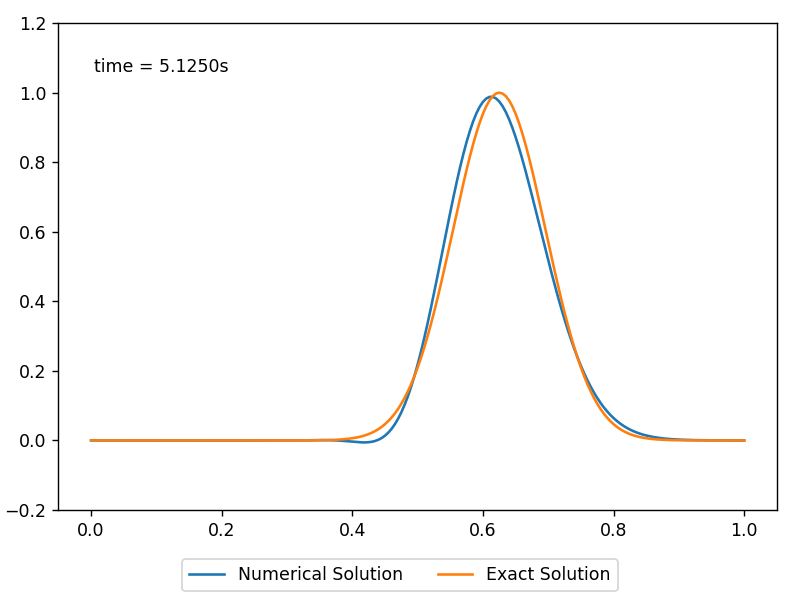

In [155]:
u, uExact, x, t = solveAdvection(gaussianHill, rk4, centralDifference, nx = 200, nt = 800, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

### Не устойчиво

Число Куранта CFL = 2.844950213371266


<IPython.core.display.Javascript object>


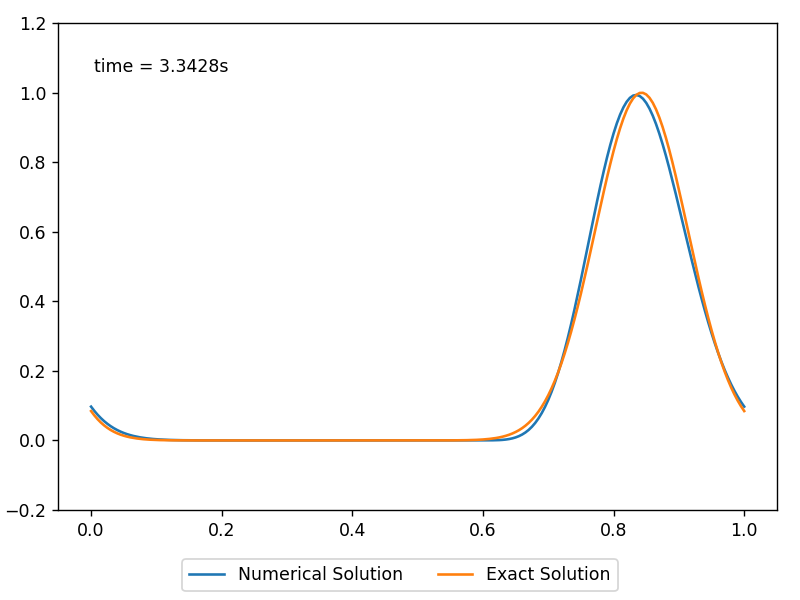

In [156]:
u, uExact, x, t = solveAdvection(gaussianHill, rk4, centralDifference, nx = 200, nt = 703, c=1.0,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Число стадий 4, число Курранта в районе 2.84

In [157]:
rk4_currant=2.8/4
rk4_currant

0.7

# Теперь тест нашего алгоритма

Тесты показали что при $\sigma=10.95$ метод устойчив

Число Куранта CFL = 10.95


<IPython.core.display.Javascript object>


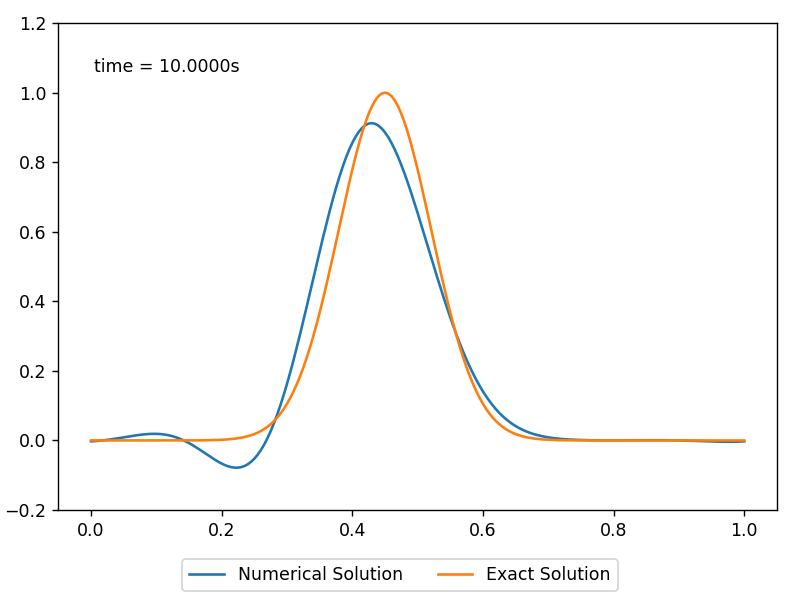

In [158]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.095,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

А при $\sigma=11$ метод уже неустойчив

Число Куранта CFL = 11.000000000000002


<IPython.core.display.Javascript object>


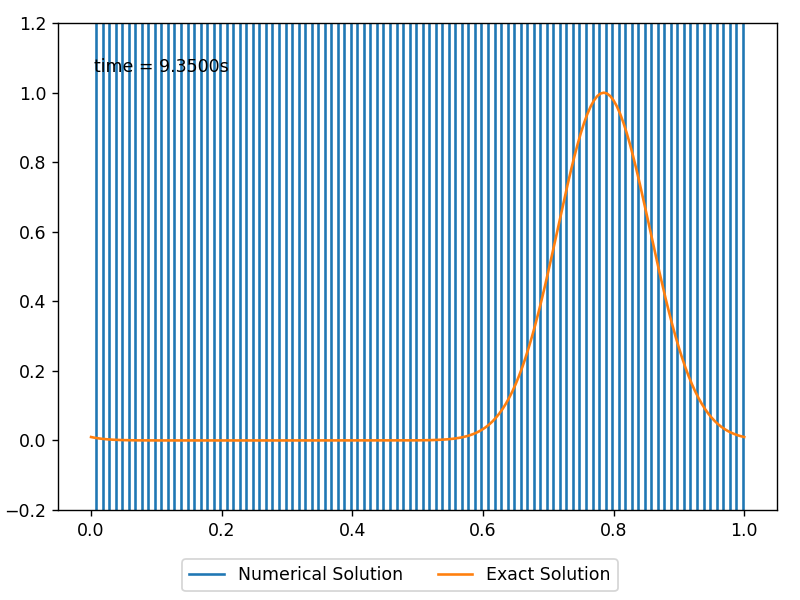

In [159]:
u, uExact, x, t = solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = 200, nt = 200, c=1.1,T=10)
anim = animateAdvection(u, uExact, x, t,timespeed=4)

Отсюда можно получить, что $\sigma = 10.975 \pm 00.030$

Число Курранта 10.975, число стадий 12

In [160]:
sch12_currant=10.975/12
sch12_currant

0.9145833333333333

Напомним, что у RK4 было

In [161]:
rk4_currant

0.7

__Вывод__ : в рассчете на один шаг, у _рассматриваемого алгоритма_ число курранта больше, чем у _RK4_

# __ В процессе __ Область устойчивости lsrk __ В процессе __

Чтобы выписать функцию устойчивости, нужно получить коэффициенты из таблицы Бутчера

Связь между коэффициентами метода и классическими коэффициентами таблицы Бутчера дается рекурсивными выражениями :

![include](coefficients.png)

Наши коэффициенты

In [162]:
A=[0.0000000000000000,
    -0.0923311242368072,
    -0.9441056581158819,
    -4.3271273247576394,
    -2.1557771329026072,
    -0.9770727190189062,
    -0.7581835342571139,
    -1.7977525470825499,
    -2.6915667972700770,
    -4.6466798960268143,
    -0.1539613783825189,
    -0.5943293901830616]
B=[0.0650008435125904,
    0.0161459902249842,
    0.5758627178358159,
    0.1649758848361671,
    0.3934619494248182,
    0.0443509641602719,
    0.2074504268408778,
    0.6914247433015102,
    0.3766646883450449,
    0.0757190350155483,
    0.2027862031054088,
    0.2167029365631842]
c=[0.0000000000000000,
    0.0650008435125904,
    0.0796560563081853,
    0.1620416710085376,
    0.2248877362907778,
    0.2952293985641261,
    0.3318332506149405,
    0.4094724050198658,
    0.6356954475753369,
    0.6806551557645497,
    0.7143773712418350,
    0.9032588871651854]

Ищем коэффициенты таблицы Бутчера

In [133]:
#Вычисляем матрицу A
a=np.zeros((12,12))
for i in range(12):
    for j in range(i-1,-1,-1):
        if (j == i-1):
            a[i][j]=B[j]
            continue
        if (j < i-1):
            a[i][j]=A[j+1]*a[i][j+1]+B[j]

In [137]:
#Вычисляем столбец b
b=np.zeros(12)
s=11
for i in range(len(b)-1,-1,-1):
    if(i==s):
        b[i]=B[i]
    if(i<s):
        b[i]=A[i+1]*b[i+1]+B[i]

In [140]:
#Чтобы можно было умножать
c=np.array(c)

Функция устойчивости для методов Рунге-Кутты :

$$G(z)=1+\gamma_1z+\gamma_2z^2+...+\gamma_nz^n$$

где коэффициенты $\gamma$ находятся по формуле

![include](gammas.png)

In [164]:
gammas=np.zeros(len(b))
gammas[0]=np.sum(b)
for i in range(1,len(b)):
    matrix_tmp=np.linalg.matrix_power(a,i-1)
    vector_tmp=np.dot(b.T,matrix_tmp)
    gammas[i]=np.dot(vector_tmp,c)

In [165]:
print(gammas)

[1.00000000e+00 5.00000000e-01 1.66666667e-01 4.16666667e-02
 7.77931143e-03 1.29736312e-03 1.48202140e-04 1.85511010e-05
 1.23518869e-06 1.23777688e-07 3.74345299e-09 3.12788905e-10]


Теперь выведем нашу функцию

In [166]:
function_str="G(z) = 1 "
for i in range(len(gammas)):
    function_str+="+ {}z^{}".format(gammas[i],i)

In [167]:
function_str

'G(z) = 1 + 1.0000000000000002z^0+ 0.5z^1+ 0.16666666666666677z^2+ 0.04166666666666668z^3+ 0.007779311434501866z^4+ 0.001297363116218036z^5+ 0.00014820214027731432z^6+ 1.8551101042762935e-05z^7+ 1.2351886928579289e-06z^8+ 1.2377768810554024e-07z^9+ 3.743452990041488e-09z^10+ 3.127889052198838e-10z^11'

Построим область устойчивости в Mapple :

Mapple умирает, когда пытаюсь загнать в него эту функцию. Нужно будет перепроверить что коэффициенты найдены корректно

# Сравенение скоростей

Будем теперь менять общее время, подстраивая nt и nx так, чтобы оба метода держались на близких к предельным числам Курранта. Для rk4 это будет 2.5, для LSRK это будет 10

In [45]:
TIMES=[10,20,30,40,50,60,70,80,90,100]
times_rk4=[]
times_LSRK=[]
nx=1000 #Число узлов пространственной сетки фиксируем
c=1 #Скорость

In [48]:
import math
dx=1/nx
dt=10*dx/c
nt=math.ceil(10/dt)

In [50]:
from math import ceil
import time
for global_time in TIMES:
    
    iteration_start=time.time()
    dx=1/nx                     #Считаем шаг сетки по пространству
    dt=10*dx/c                 #Считаем шаг сетки по времени
    nt=ceil(global_time/dt)     #Считаем число узлов во временной сетке
    solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx=nx, nt = nt, c=c,T=global_time)
    iteration_end=time.time()
    times_LSRK.append(iteration_end-iteration_start)
    
    iteration_start=time.time()
    dx=1/nx                     #Считаем шаг сетки по пространству
    dt=2.5*dx/c                  #Считаем шаг сетки по времени
    nt=ceil(global_time/dt)     #Считаем число узлов во временной сетке
    solveAdvection(gaussianHill, rk4, centralDifference, nx=nx, nt = nt, c=1.0,T=global_time)
    iteration_end=time.time()
    times_rk4.append(iteration_end-iteration_start)        

Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5
Число Куранта CFL = 10.0
Число Куранта CFL = 2.5


<IPython.core.display.Javascript object>


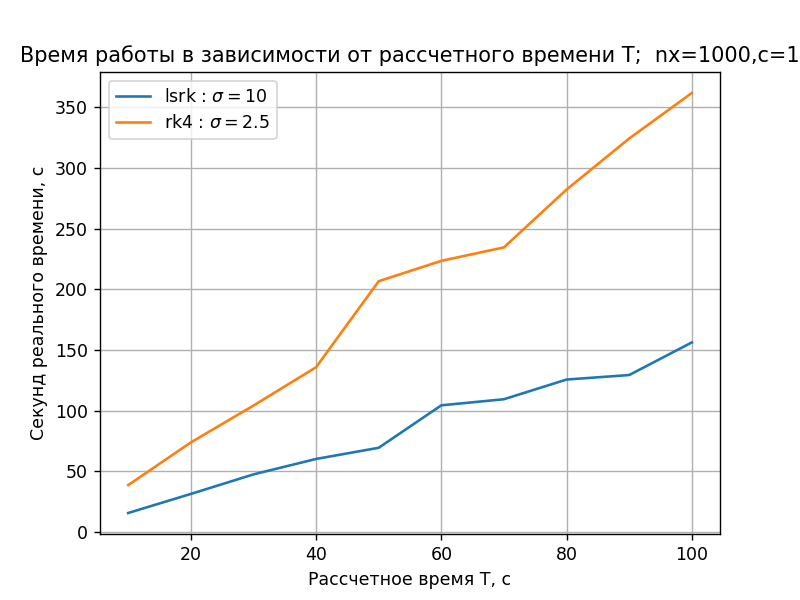

Text(0.5,1,'Время работы в зависимости от рассчетного времени T;  nx=1000,c=1')

In [168]:
plt.close()
%matplotlib notebook
plt.plot(TIMES,times_LSRK,label=r'lsrk : $\sigma = 10$')
plt.plot(TIMES,times_rk4,label=r'rk4 : $\sigma = 2.5$')
plt.legend()
plt.ylabel("Секунд реального времени, с")
plt.xlabel("Рассчетное время T, с")
plt.grid()
plt.title("Время работы в зависимости от рассчетного времени T;  nx=1000,c=1")

### Проверим, не портится ли порядок сходимости при числах Куранта близким к максимальным

In [173]:
def get_norm(u,uExact,dx): #Считаем L_2^h норму разности точного и численного решений
    numerical=u
    exact=uExact
    nx=len(numerical)
    dif=np.abs(numerical-exact)
    dif=np.square(dif)
    dif*=dx
    return np.sum(dif)

In [174]:
rk4_nx = 200
rk4_nt = 800
lsrk_nx= 200
lsrk_nt= 200

In [175]:
rk4_results = solveAdvection(gaussianHill, rk4, centralDifference, nx = rk4_nx, nt = rk4_nt, c=1.0,T=10)
lsrk_results= solveAdvection(gaussianHill, LSRK_inviscid, centralDifference, nx = lsrk_nx, nt = lsrk_nt, c=1.0,T=10)

Число Куранта CFL = 2.5
Число Куранта CFL = 10.0


In [176]:
rk4_u       = rk4_results[0]
rk4_uExact  = rk4_results[1]
lsrk_u      = lsrk_results[0]
lsrk_uExact = lsrk_results[1]

Рассмотрим 20 точек по времени и ошибку в этих точках

In [183]:
n_points=20
N=int(lsrk_nt/n_points)             #Сколько тиков между точками для lsrk
rk4_times=list(range(0,800,4*N))    #В каких точках брать значения rk4
lsrk_times=list(range(0,200,N))     #В каких точках брать значения lsrk                
xaxis=np.linspace(0,10,n_points)    #Разметка этих точек на оси времени
rk4_yaxis=np.zeros(n_points)
lsrk_yaxis=np.zeros(n_points)
for i in range(int(n_points)):      #Заполняем нормы
    rk4_yaxis[i]  = get_norm( rk4_u[rk4_times[i]]   , rk4_uExact[rk4_times[i]]   ,1/rk4_nx)
    lsrk_yaxis[i] = get_norm( lsrk_u[lsrk_times[i]] , lsrk_uExact[lsrk_times[i]] ,1/lsrk_nx)

<IPython.core.display.Javascript object>


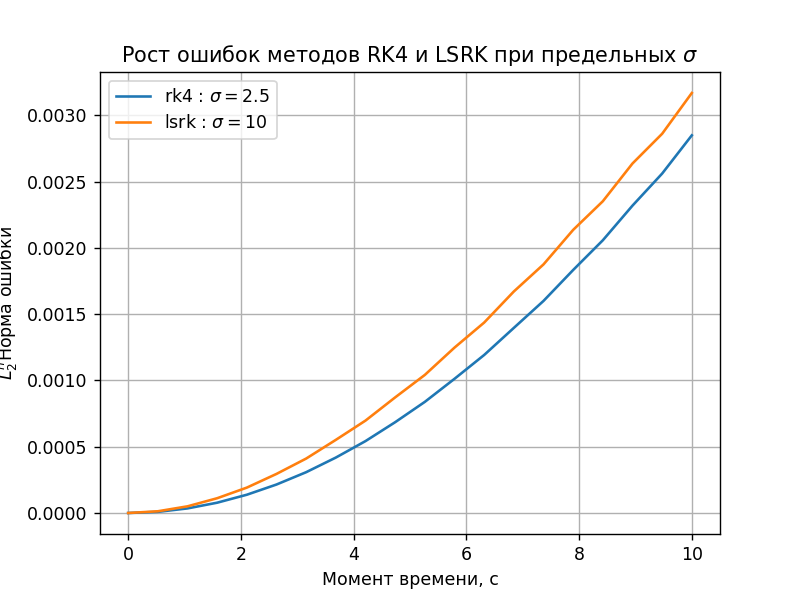

In [184]:
plt.close()
%matplotlib notebook
plt.plot(xaxis,rk4_yaxis,label=r'rk4 : $\sigma=2.5$')
plt.plot(xaxis,lsrk_yaxis,label=r'lsrk : $\sigma=10$')
plt.ylabel(r"$L_2^h $Норма ошибки")
plt.xlabel("Момент времени, с")
plt.title("Рост ошибок методов RK4 и LSRK при предельных $\sigma$")
plt.grid()
plt.legend()